
# Proyecciones Locales Cuantílicas con datos macroeconómicos

En este notebook se utiliza el conjunto de datos `macrodata` de `statsmodels` para ilustrar la construcción y estimación de proyecciones locales (LP) y proyecciones locales cuantílicas (QLP). A lo largo de este ejemplo se explican los pasos de carga de paquetes, procesamiento de datos, definición de un shock, estimación de los modelos y validación gráfica de los resultados.


In [12]:

# Cargar paquetes necesarios
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
sns.set(style="whitegrid")



## Carga de datos y creación del índice temporal

Usaremos el conjunto de datos `macrodata` de `statsmodels`, que contiene series trimestrales de variables macroeconómicas de EE. UU. desde 1959Q1 hasta 2009Q3. Para trabajar con series de tiempo, creamos un índice temporal basado en la frecuencia trimestral.


In [13]:

# Cargar datos y crear índice temporal trimestral
data = sm.datasets.macrodata.load_pandas().data
# Crear periodo trimestral y fijarlo como índice
data['date'] = pd.period_range(start='1959Q1', periods=len(data), freq='Q')
data.set_index('date', inplace=True)

# Mostrar las primeras filas para verificar
print(data.head())


          year  quarter   realgdp  realcons  realinv  realgovt  realdpi  \
date                                                                      
1959Q1  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9   
1959Q2  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7   
1959Q3  1959.0      3.0  2775.488    1751.8  289.226   491.260   1916.4   
1959Q4  1959.0      4.0  2785.204    1753.7  299.356   484.052   1931.3   
1960Q1  1960.0      1.0  2847.699    1770.5  331.722   462.199   1955.5   

          cpi     m1  tbilrate  unemp      pop  infl  realint  
date                                                           
1959Q1  28.98  139.7      2.82    5.8  177.146  0.00     0.00  
1959Q2  29.15  141.7      3.08    5.1  177.830  2.34     0.74  
1959Q3  29.35  140.5      3.82    5.3  178.657  2.74     1.09  
1959Q4  29.37  140.0      4.33    5.6  179.386  0.27     4.06  
1960Q1  29.54  139.6      3.50    5.2  180.007  2.31     1.19  



## Limpieza y procesamiento de datos

Trabajaremos con el crecimiento del PIB real (`realgdp`) como variable de interés. Calcularemos el crecimiento logarítmico trimestral:

\[ \Delta y_t = \log(	ext{realgdp}_t) - \log(	ext{realgdp}_{t-1}) \]

Para el choque exógeno, construiremos una variable indicadora que tome valor 1 cuando la tasa de los bonos del Tesoro a 3 meses (`tbilrate`) aumenta respecto al trimestre anterior (simulando un shock monetario restrictivo) y 0 en caso contrario. Consideraremos esta variable como exógena a efectos ilustrativos.


In [14]:

# Calcular crecimiento logarítmico del PIB real
data['realgdp_growth'] = np.log(data['realgdp']).diff()

# Definir el shock: 1 si la tasa del T-bill aumenta, 0 en caso contrario
interest_diff = data['tbilrate'].diff()
data['shock'] = (interest_diff > 0).astype(int)

# Eliminar la primera observación por valores NA en las diferencias
data = data.dropna(subset=['realgdp_growth', 'shock'])

print(data[['realgdp_growth', 'tbilrate', 'shock']].head())


        realgdp_growth  tbilrate  shock
date                                   
1959Q2        0.024942      3.08      1
1959Q3       -0.001193      3.82      1
1959Q4        0.003495      4.33      1
1960Q1        0.022190      3.50      0
1960Q2       -0.004685      2.68      0



## Configuración para las proyecciones locales y cuantílicas

Vamos a estimar cómo responde el crecimiento del PIB real a un shock de la tasa de interés. Para ello:

1. Definimos horizontes de 0 a 4 trimestres (un año).
2. Para cada horizonte \(h\), calculamos el cambio de la variable de interés \(\Delta y_{t+h}\).
3. Incluimos un intercepto y el valor rezagado de `realgdp_growth` como control en la regresión.
4. Estimamos las proyecciones locales mediante OLS y las proyecciones locales cuantílicas para los cuantiles 0.25, 0.50 y 0.75.

Suponemos que el shock (variable `shock`) es exógeno con respecto al crecimiento del PIB y a otras variables incluidas en la regresión, lo que permite identificar el efecto causal del shock en el crecimiento.


In [15]:
# Definir los horizontes y listas para almacenar resultados
horizons = range(0, 5)
responses_mean, responses_q25, responses_q50, responses_q75 = [], [], [], []

for h in horizons:
    # Variable dependiente: crecimiento a horizonte h
    if h == 0:
        dy = data['realgdp_growth']
    else:
        dy = data['realgdp_growth'].shift(-h) - data['realgdp_growth']
    
    # Construir un DataFrame temporal con las variables relevantes
    df_tmp = pd.DataFrame({
        'dy': dy,
        'shock': data['shock'],
        'lag_growth': data['realgdp_growth'].shift(1)
    }).dropna()  # elimina cualquier fila con NaN
    
    # Dependiente y regresores alineados sin faltantes
    y_tmp = df_tmp['dy']
    X_tmp = sm.add_constant(df_tmp[['shock', 'lag_growth']])
    
    # Estimación OLS
    model_ols = sm.OLS(y_tmp, X_tmp).fit()
    responses_mean.append(model_ols.params['shock'])
    
    # Estimación cuantílica
    for tau, store in zip([0.25, 0.50, 0.75], [responses_q25, responses_q50, responses_q75]):
        model_qr = sm.QuantReg(y_tmp, X_tmp).fit(q=tau)
        store.append(model_qr.params['shock'])


In [16]:
# Definir los horizontes y listas para almacenar resultados
horizons = range(0, 5)
responses_mean, responses_q25, responses_q50, responses_q75 = [], [], [], []

for h in horizons:
    # Variable dependiente: crecimiento de y en t+h
    if h == 0:
        dy = data['realgdp_growth']
    else:
        dy = data['realgdp_growth'].shift(-h) - data['realgdp_growth']

    # Construir DataFrame con la dependiente y los regresores
    df_tmp = pd.DataFrame({
        'dy': dy,
        'shock': data['shock'],
        'lag_growth': data['realgdp_growth'].shift(1)
    }).dropna()  # eliminar cualquier fila con NaN

    # Extraer dependiente y regresores sin NaN
    y_tmp = df_tmp['dy']
    X_tmp = sm.add_constant(df_tmp[['shock', 'lag_growth']])

    # Estimación OLS
    model_ols = sm.OLS(y_tmp, X_tmp).fit()
    responses_mean.append(model_ols.params['shock'])

    # Estimaciones cuantílicas
    for tau, store in zip([0.25, 0.50, 0.75], [responses_q25, responses_q50, responses_q75]):
        model_qr = sm.QuantReg(y_tmp, X_tmp).fit(q=tau)
        store.append(model_qr.params['shock'])


In [17]:
# Tras el bucle que calcula responses_mean, responses_q25, etc.
results = pd.DataFrame({
    'Horizonte': list(horizons),
    'OLS (media)': responses_mean,
    'Cuantil 0.25': responses_q25,
    'Cuantil 0.50': responses_q50,
    'Cuantil 0.75': responses_q75
})

print(results)


   Horizonte  OLS (media)  Cuantil 0.25  Cuantil 0.50  Cuantil 0.75
0          0     0.002228      0.001571      0.001027      0.003716
1          1     0.000683     -0.000902      0.000135      0.001003
2          2    -0.002097     -0.001085     -0.000424     -0.000810
3          3    -0.004103     -0.002196     -0.003503     -0.002581
4          4    -0.002968     -0.002711     -0.003751     -0.005251



## Gráficos de las respuestas de impulso

Para comparar las respuestas medias y cuantílicas, elaboramos un gráfico de líneas que muestre la estimación de \(eta_{h}\) o \(eta_{h,	au}\) a lo largo de los horizontes. Las curvas permiten apreciar la heterogeneidad en los efectos del shock sobre la distribución del crecimiento del PIB.


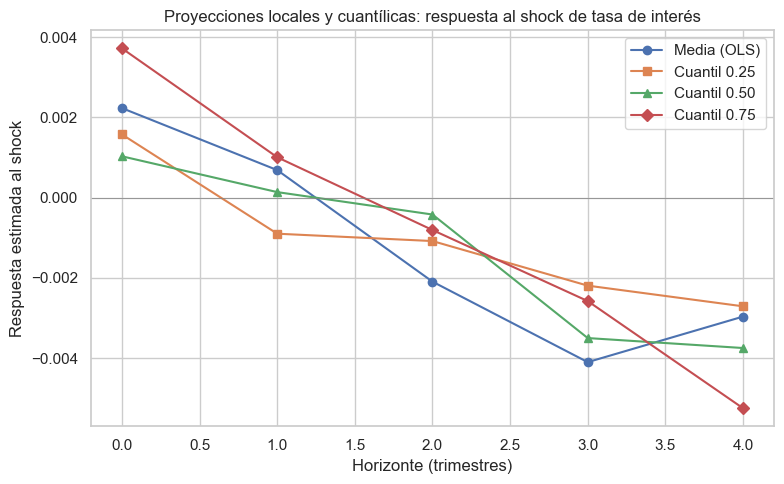

In [18]:

plt.figure(figsize=(8, 5))
plt.plot(results['Horizonte'], results['OLS (media)'], marker='o', label='Media (OLS)')
plt.plot(results['Horizonte'], results['Cuantil 0.25'], marker='s', label='Cuantil 0.25')
plt.plot(results['Horizonte'], results['Cuantil 0.50'], marker='^', label='Cuantil 0.50')
plt.plot(results['Horizonte'], results['Cuantil 0.75'], marker='D', label='Cuantil 0.75')
plt.axhline(0, color='gray', linewidth=0.5)
plt.xlabel('Horizonte (trimestres)')
plt.ylabel('Respuesta estimada al shock')
plt.title('Proyecciones locales y cuantílicas: respuesta al shock de tasa de interés')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Interpretación y validación

- **Interpretación:** Las respuestas de impulso muestran que el shock monetario restrictivo (aumento de la tasa de interés) tiene efectos heterogéneos sobre el crecimiento del PIB. Por ejemplo, los cuantiles inferiores muestran efectos negativos mayores en el horizonte inmediato, mientras que la media puede ocultar dichas caídas.
- **Supuestos:** Suponemos exogeneidad del shock y que los controles (rezagos) capturan la dinámica endógena. Se requiere que las series sean estacionarias; aquí usamos diferencias logarítmicas para el PIB y una variable binaria para el shock.
- **Validación:** Para un análisis más riguroso se podrían obtener intervalos de confianza mediante métodos bootstrap o errores estándar robustos a heterocedasticidad (HAC). Además, se podría comprobar la estabilidad temporal de los coeficientes y analizar otras variables de control.
